# **Introduction à l'apprentissage automatique**

Il est maintenant temps de tenter de prédire le rendement d'avoine en fonction des variables que nous avons définies. 




Nous ne traiterons pas le jeu de données comme une série chronologique.  L'année, bien que présente, sera considérée comme une caractéristique dans le jeu de données.  
Nous ne voulons pas prédire le rendement futur en nous basant sur le passé.  Nous tenterons plutôt de prédire le rendement compte tenu des caractéristiques actuelles comme 
la température et la quantité de précipitations.

## Rappel 

Pour l'apprentissage supervisé, par convention, nous utilisons deux matrices, soient $X$ et $y$. 

$X$, contient les caractéristiques (*features*) et est de taille $n \times p$, où $n$ est le nombre d'exemples (observations) et $p$ est le nombre de caractéristiques (dimensionnalité).

$$X = \begin{bmatrix} 
f_{11} & f_{12} & \ldots & f_{1p} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
f_{n1} & f_{12} & \ldots & f_{np} \\
\end{bmatrix}
$$ 



$y$, est en fait un vecteur qui contient les étiquettes associées à chaque exemple. Il est donc de taille $n$. 


$$
y = \begin{bmatrix} 
e_1 \\
e_2 \\
\vdots \\ 
e_n
\end{bmatrix}$$

$X$ et $y$ doivent toujours être ordonnés de la même façon, i.e. pour un index $i$, les données de $X_i$ correspondent à l'étiquette $y_i$.



Comme nous entrainons des modèles sur un ensemble d'entrainement (`train`) et testons leurs performances sur un ensemble de test (`test`), nous dénotons ces ensembles comme $X_\text{train}$ et $X_\text{test}$ et $Y_\text{train}$ et $Y_\text{test}$.

## Installation et chargement des librairies nécessaires

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  
Voici une description de certaines des librairies utilisées.
- `missingo` permet de visualiser rapidement les données manquantes
- `sklearn`  scikit-learn est un incontournable pour faire de l'apprentissage automatique
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)

In [1]:
#!pip install missingno
#!pip install statsmodels
#!pip install scikit-learn 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math


import missingno
import statsmodels.api as sm

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, BaggingRegressor,
                              GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.datasets import make_regression
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, f1_score, mean_absolute_error,
                            confusion_matrix, classification_report, roc_auc_score, recall_score)


sns.set(font_scale=0.9, style='whitegrid')
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"] # IVADO palette

%matplotlib inline

## Chargement des données

Nous allons utiliser les données que nous avons préparées lors de la séance de Nettoyage de données.

Le jeu de données contient des données météorologiques et de rendement d'avoine collectées entre 2004 et 2022 pour un nombre de régions ontariennes.

Nous voulons prédire le rendement d'avoine.  La tâche relève donc de l'apprentissage supervisé et est une tâche de régression.  

Nous voulons prédire un nombre et non une catégorie (étiquette).

In [2]:
df = pd.read_csv('dataset_v1.csv', index_col=0)

De quoi a l'air la distribution de la variable cible à prédire ?

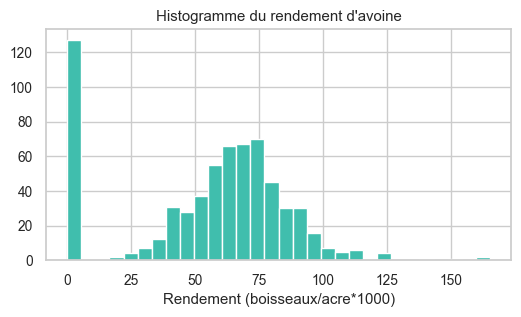

In [3]:
_ = plt.figure(figsize=(6,3))
df.Rendement.hist(bins=30, color=colors[0])
plt.title("Histogramme du rendement d'avoine")
plt.xlabel("Rendement (boisseaux/acre*1000)")
plt.show()

A-t-on des valeurs manquantes ? 

Certains algorithmes d'apprentissage automatique ne supportent pas les valeurs manquantes.  Nous devons donc les imputer ou les éliminer.  Lorsque nous avons un petit nombre d'exemples, nous voulons souvent en conserver le maximum, donc l'élimination n'est pas une option envisageable.

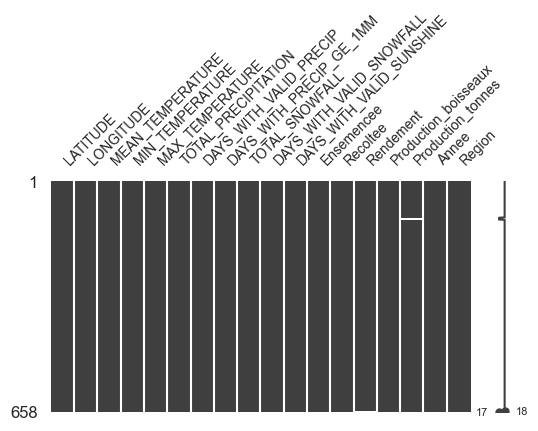

In [4]:
# Visualisons les valeurs manquantes
missingno.matrix(df, figsize=(6,3), fontsize=10)
plt.show()

Nous avons quelques valeurs de NaN pour la production de boisseaux en tonnes et pour le rendement.

Le graphique de `missingo` ne représente que les NaN.  Qu'en est-il du rendement égal à  0 ?

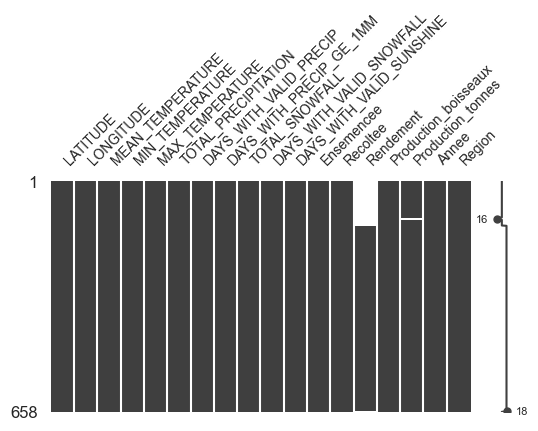

In [5]:
mx = df.copy()
mx.loc[mx.Rendement==0, 'Rendement'] = np.nan
missingno.matrix(mx, figsize=(6,3), fontsize=10)
plt.show()

Est-ce qu'une valeur de 0 lorsque nous avons une valeur de Production (boisseaux et tonnes) est un vrai 0?

In [6]:
df.loc[(df.Rendement == 0) & (df.Production_boisseaux != 0), :]

,LATITUDE,LONGITUDE,MEAN_TEMPERATURE,MIN_TEMPERATURE,MAX_TEMPERATURE,TOTAL_PRECIPITATION,DAYS_WITH_VALID_PRECIP,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,DAYS_WITH_VALID_SNOWFALL,DAYS_WITH_VALID_SUNSHINE,Ensemencee,Recoltee,Rendement,Production_boisseaux,Production_tonnes,Annee,Region
0,45.054,-76.784,9.797829,-24.0,32.5,901.4,352.0,120.0,168.8,352.0,0.0,27.592198,23.281722,0.0,0.796741,0.016182,2021,Frontenac
0,44.403,-76.908,10.057898,-23.5,34.0,815.9,360.0,111.0,115.8,360.0,0.0,1122.657562,947.275062,0.0,38.955752,0.791191,2021,Lennox And Addington


Nous n'avons que deux cas où le rendement est 0 et la production de boisseaux n'est pas 0. Est-ce une erreur?

Comme nous voulons prédire le rendement, nous ne garderons que les exemples qui ont une valeur de rendement supérieure à 0.

In [7]:
df = df.loc[df.Rendement > 0, :].reset_index()
df = df.iloc[:,1:]

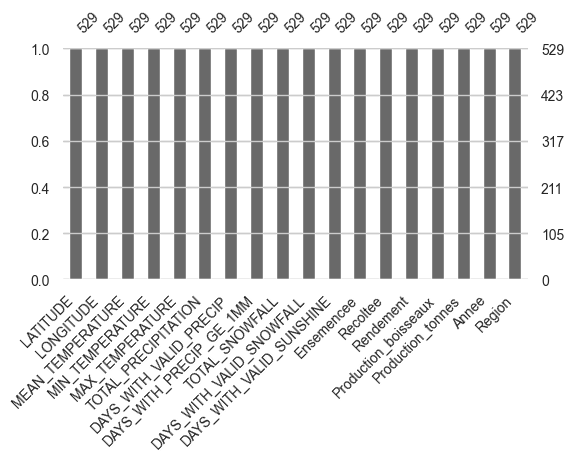

In [8]:
# Autre façon de visualiser les données manquantes.
missingno.bar(df, figsize=(6,3), fontsize=10)
plt.show()

In [9]:
# Nombre de données manquantes par variable
df.isna().sum(0)

LATITUDE                    0
LONGITUDE                   0
MEAN_TEMPERATURE            0
MIN_TEMPERATURE             0
MAX_TEMPERATURE             0
TOTAL_PRECIPITATION         0
DAYS_WITH_VALID_PRECIP      0
DAYS_WITH_PRECIP_GE_1MM     0
TOTAL_SNOWFALL              0
DAYS_WITH_VALID_SNOWFALL    0
DAYS_WITH_VALID_SUNSHINE    0
Ensemencee                  0
Recoltee                    0
Rendement                   0
Production_boisseaux        0
Production_tonnes           0
Annee                       0
Region                      0
dtype: int64

In [10]:
df.isnull().any()

LATITUDE                    False
LONGITUDE                   False
MEAN_TEMPERATURE            False
MIN_TEMPERATURE             False
MAX_TEMPERATURE             False
TOTAL_PRECIPITATION         False
DAYS_WITH_VALID_PRECIP      False
DAYS_WITH_PRECIP_GE_1MM     False
TOTAL_SNOWFALL              False
DAYS_WITH_VALID_SNOWFALL    False
DAYS_WITH_VALID_SUNSHINE    False
Ensemencee                  False
Recoltee                    False
Rendement                   False
Production_boisseaux        False
Production_tonnes           False
Annee                       False
Region                      False
dtype: bool

Comme il n'y a pas de valeurs manquantes, nous allons en créer.


In [11]:
df.loc[df.sample(10).index, 'TOTAL_SNOWFALL'] = np.nan 
# Nombre de données manquantes par variable
df.isna().sum(0)

LATITUDE                     0
LONGITUDE                    0
MEAN_TEMPERATURE             0
MIN_TEMPERATURE              0
MAX_TEMPERATURE              0
TOTAL_PRECIPITATION          0
DAYS_WITH_VALID_PRECIP       0
DAYS_WITH_PRECIP_GE_1MM      0
TOTAL_SNOWFALL              10
DAYS_WITH_VALID_SNOWFALL     0
DAYS_WITH_VALID_SUNSHINE     0
Ensemencee                   0
Recoltee                     0
Rendement                    0
Production_boisseaux         0
Production_tonnes            0
Annee                        0
Region                       0
dtype: int64


## Imputation des valeurs manquantes
Il existe plusieurs stratégies pour gérer les valeurs manquantes.  

Il faut faire bien attention pour ne pas introduire de biais et pour ne pas créer une fuite de données (*data leakage*). 


C'est pourquoi nous séparons nos données en ensemble d'entrainement et de test avant de faire l'imputation.
Le choix de la méthode d'imputation devient un paramètre à ajuster dans notre protocole. 

Nous allons d'abord passer à travers les étapes une à une.  Nous utiliserons ensuite les fonctions de `Pipeline` de `scikit-learn` pour s'organiser.


### Création de la matrice X et du vecteur 

In [12]:
df.columns

Index(['LATITUDE', 'LONGITUDE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE',
       'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'DAYS_WITH_VALID_PRECIP',
       'DAYS_WITH_PRECIP_GE_1MM', 'TOTAL_SNOWFALL', 'DAYS_WITH_VALID_SNOWFALL',
       'DAYS_WITH_VALID_SUNSHINE', 'Ensemencee', 'Recoltee', 'Rendement',
       'Production_boisseaux', 'Production_tonnes', 'Annee', 'Region'],
      dtype='object')

In [13]:
cols = ['DAYS_WITH_VALID_SUNSHINE','DAYS_WITH_VALID_PRECIP', 
        'MEAN_TEMPERATURE', 'MIN_TEMPERATURE','DAYS_WITH_PRECIP_GE_1MM','TOTAL_SNOWFALL', 
        'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'Annee', 'LATITUDE', 'LONGITUDE']

X = df.loc[:, cols]  # Caractéristiques (température, precipitation, etc.)
y = df.Rendement  # Valeurs cibles (rendement)

### Création des ensembles d'entrainement et de test

Rappel :  L'ensemble de test doit être mis de côté et on ne doit pas y toucher avant l'évaluation finale de notre modèle. 


In [14]:
# Division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputation des valeurs manquantes en utilisant les classes de scikit-learn


Les classes de `scikit-learn` implémentant des transformations s'utilisent toujours de la même façon : en utilisant les méthodes `fit` et `transform`. 

Nous verrons que les classes implémentant des prédicteurs fonctionnent aussi de façon similaire : avec les méthodes `fit` et `predict`. 



In [15]:
# SimpleImputer (imputation par la moyenne)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

X_train_mean = pd.DataFrame(imp.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_mean = pd.DataFrame(imp.transform(X_test), columns=X_test.columns, index=X_test.index)

In [16]:
# IterativeImputer (imputation par estimation)
imp_it = IterativeImputer(max_iter=10, random_state=0)
imp_it.fit(X_train)

X_train_it = pd.DataFrame(imp_it.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_it = pd.DataFrame(imp_it.transform(X_test), columns=X_test.columns, index=X_test.index)

### À votre tour  
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Vérifiez que la valeur imputée est bien celle attendue. 

In [17]:
var = 'TOTAL_SNOWFALL'
mean_val = df.loc[X_train.index, var].mean()
print(F"La valeur moyenne de la variable TOTAL_SNOWFALL dans l'ensemble d'entrainement est de {round(mean_val, 6)}.")

print('Voici 2 rangées des valeurs imputées')
ix = df.loc[df[var].isnull(),:].index

La valeur moyenne de la variable TOTAL_SNOWFALL dans l'ensemble d'entrainement est de 110.341977.
Voici 2 rangées des valeurs imputées


In [18]:
print("-----------------------")
print("Ensemble d'entrainement")
print("-----------------------")
print(X_train_mean.loc[X_train_mean.index.isin(ix),:].head(2))

-----------------------
Ensemble d'entrainement
-----------------------
     DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
114                       0.0                   354.0          3.565000   
408                       0.0                   359.0          5.634194   

     MIN_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  TOTAL_SNOWFALL  \
114           -26.60                    122.0      110.341977   
408           -42.35                     88.0      110.341977   

     MAX_TEMPERATURE  TOTAL_PRECIPITATION   Annee  LATITUDE  LONGITUDE  
114             31.2               935.20  2018.0   45.2330    -81.633  
408             33.5               531.95  2011.0   48.7055    -93.031  


In [19]:
print("-----------------------")
print("Ensemble de test")
print("-----------------------")
print(X_test_mean.loc[X_test_mean.index.isin(ix),:].head(2))

-----------------------
Ensemble de test
-----------------------
    DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
70                       0.0                   358.0          7.102823   

    MIN_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  TOTAL_SNOWFALL  MAX_TEMPERATURE  \
70           -26.65                    125.0      110.341977             32.2   

    TOTAL_PRECIPITATION   Annee  LATITUDE  LONGITUDE  
70               982.75  2006.0   45.3395    -80.035  


Comment se comparent les valeurs imputées par les deux méthodes ?

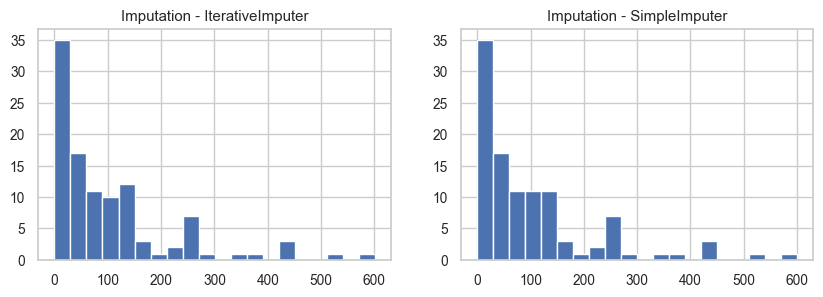

In [20]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
X_test_it[var].hist(bins=20)
plt.title('Imputation - IterativeImputer')

plt.subplot(122)
X_test_mean[var].hist(bins=20)
plt.title('Imputation - SimpleImputer')
plt.show()

In [21]:
print("Voici les valeurs imputées dans l'ensemble de test avec la méthode itérative")
X_test_it.loc[X_test_it.index.isin(ix),:]

Voici les valeurs imputées dans l'ensemble de test avec la méthode itérative


,DAYS_WITH_VALID_SUNSHINE,DAYS_WITH_VALID_PRECIP,MEAN_TEMPERATURE,MIN_TEMPERATURE,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,MAX_TEMPERATURE,TOTAL_PRECIPITATION,Annee,LATITUDE,LONGITUDE
70,0.0,358.0,7.102823,-26.65,125.0,141.787037,32.2,982.75,2006.0,45.3395,-80.035


Quelle methode d'imputation choisir ?

La documentation de `scikit-learn` est très complète.  Il existe d'autres méthodes qui peuvent être utilisées. 

https://scikit-learn.org/stable/modules/impute.html

Lorsque nous parlons de données manquantes, il faut faire attention pour ne pas introduire de biais. Les données peuvent être manquantes par hasard ou elles peuvent être manquantes pour des raisons bien particulières.

Il existe trois types de données manquantes : 

* données manquantes complètement au hasard (MCAR : missing completely at random)
* données manquantes au hasard (MAR : missing at random) 
* données manquantes non au hasard (MNAR : missing not at random) 

Le type de données manquantes et le choix de méthodes peuvent avoir un impact sur la qualité des données.

Pour la suite, nous utiliserons les données imputées par la méthode itérative

In [22]:
X_train = X_train_it
X_test = X_test_it

### Corrélation entre les variables


Il est important d'évaluer la corrélation entre les variables.  Les algorithmes d'apprentissage ne se comportent pas tous de la même façon.  Certains performent mieux avec des données gaussiennes, d'autres sont très sensibles aux valeurs numériques et une transformation est nécessaire, d'autres sont sensibles aux variables corrélées entre elles.

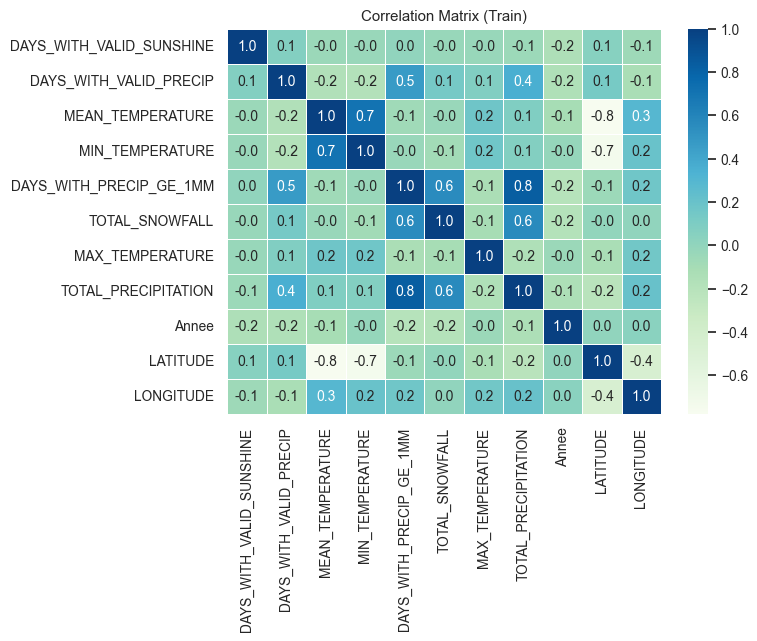

In [23]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

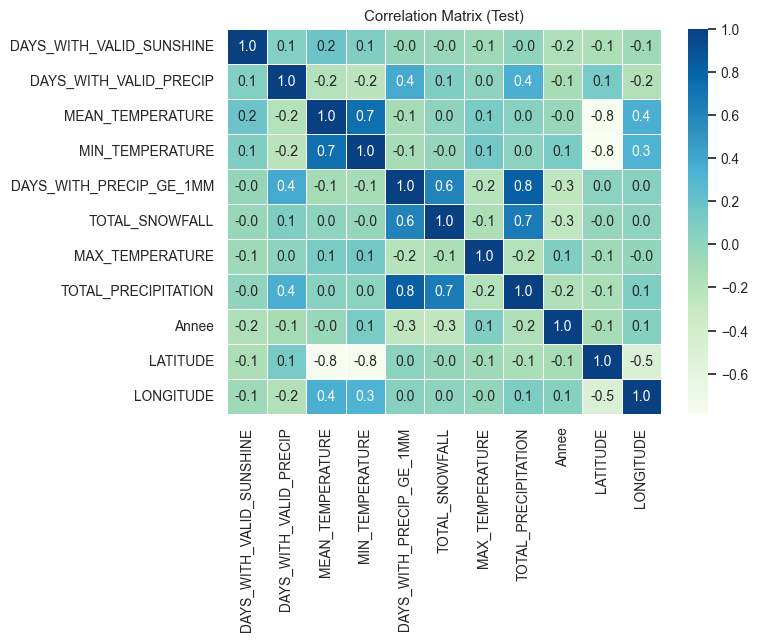

In [24]:
plt.figure(figsize=(7,5))
sns.heatmap(X_test.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Test)')
plt.show()

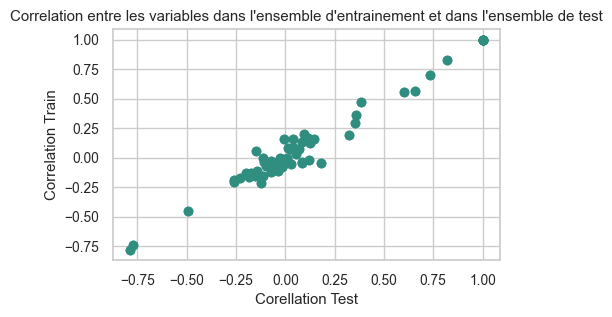

In [25]:
plt.figure(figsize=(5,3))
plt.scatter(X_test.corr(), X_train.corr(), color=colors[2])
plt.ylabel('Correlation Train')
plt.xlabel('Corellation Test')
plt.title ("Correlation entre les variables dans l'ensemble d'entrainement et dans l'ensemble de test")
plt.show()

## Transformation (normalisation, standardisation, encodage)

Des transformations sont parfois nécessaires tout dépendant des distributions des variables.  
Nous voudrons par exemple utiliser un encodage One-Hot pour les variables qualitatives (catégories) ou ramener les valeurs entre 0 et 1 pour les variables qui ne sont pas du même ordre de grandeur.

Ici, nous transformerons toutes les variables en z-score en utilisant la classe `StandardScaler`.

https://scikit-learn.org/stable/modules/preprocessing.html

In [26]:
scaler = StandardScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Prédire le rendement d'avoine

La prédiction du rendement d'avoine est une tâche de régression.  Nous voulons prédire un nombre.

Nous pourrons évaluer la performance des modèles sur nos données regardant le coefficient de détermination ($R^2$) et la $MSE$ (*mean squared error*).



Le `DummyRegressor` peut servir pour le prototypage de notre code.  Il utilise des règles très simples et expose les mêmes fonctions que les autres classes de `Regressor`.

In [27]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train_scaled, y_train)
y_pred = dummy_regressor.predict(X_test_scaled)
y_train_pred = dummy_regressor.predict(X_train_scaled)
score = dummy_regressor.score(X_test_scaled, y_test)

In [28]:
def plot_pred_vs_true(y_test, y_pred, score, model_name, y_train=None, y_train_pred=None):
    plt.figure(figsize=(4,3))
    if y_train is not None and y_train_pred is not None:
        plt.scatter(y_train, y_train_pred, label='Training data', color=colors[1])
        
    plt.scatter(y_test, y_pred, label='Test data', color=colors[0])
    plt.title('{} [test score={:.2f}]'.format(model_name, score))
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.ylim(y_test.min(), y_test.max())
    plt.show()

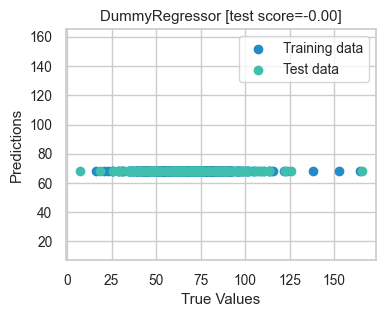

In [29]:
plot_pred_vs_true(y_test, y_pred, score, 'DummyRegressor', y_train=y_train, y_train_pred=y_train_pred)

### Forêt d'arbres aléatoire

Utilisons maintenant un `Regressor` plus pertinent, soit une forêt alétaoire (*random forest*) 

La forêt de d'arbres décision aléatoire est une méthode d'ensemble qui peut être utilisée pour les problèmes de régression et de classification  Cet algorithme non linéaire combine les prédictions de plusieurs arbres de décision.  Chaque arbre de décision de la forêt est entrainé en utilisant des caractéristiques et des exemples choisis au hasard. 

<img src='https://www.tibco.com/sites/tibco/files/media_entity/2021-05/random-forest-diagram.svg' width='450px'>

<a style='font-size:10px;' href='https://www.tibco.com/fr/reference-center/what-is-a-random-forest'>https://www.tibco.com/fr/reference-center/what-is-a-random-forest</a>

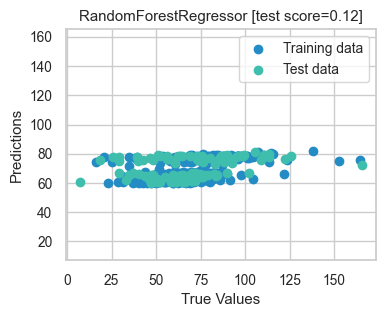

In [30]:
forest_regressor = RandomForestRegressor(max_depth=2, random_state=0)
forest_regressor.fit(X_train_scaled, y_train)
y_pred = forest_regressor.predict(X_test_scaled)
y_train_pred = forest_regressor.predict(X_train_scaled)
score = forest_regressor.score(X_test_scaled, y_test)
plot_pred_vs_true(y_test, y_pred, score, 'RandomForestRegressor', y_train=y_train, y_train_pred=y_train_pred)


In [31]:
mse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(y_pred)*100:3.3}%)')

score = forest_regressor.score(X_test_scaled, y_test)
print(f'Model determination: {score:3.3}')

Mean error: 23.0 (32.8%)
Model determination: 0.12


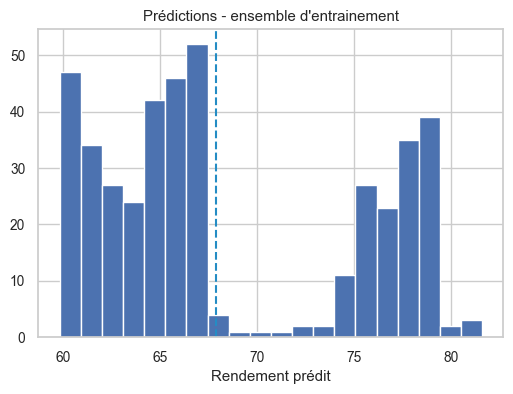

In [32]:
_ = plt.figure(figsize=(6,4))
plt.hist(y_train_pred, bins=20)
plt.title("Prédictions - ensemble d'entrainement")
plt.axvline(x=y_test.mean(), color=colors[1], linestyle='--')
plt.xlabel('Rendement prédit')
plt.show()

<span style='font-size:22px'>Pourquoi observe-t-on une distribution bi-modale? <br>
Pourquoi les prédictions se situent entre 60 et 85 seulement?
    On ne s'éloigne pas beaucoup de la moyenne. </span>

In [33]:
X_train.loc[y_train_pred < 70,:].describe().T

,count,mean,std,min,25%,50%,75%,max
DAYS_WITH_VALID_SUNSHINE,278.0,1.053062,7.194491,0.000000,0.000000,0.000000,0.000000,60.645833
DAYS_WITH_VALID_PRECIP,278.0,346.601493,26.169404,202.000000,340.125000,357.666667,363.500000,366.000000
MEAN_TEMPERATURE,278.0,7.287149,1.811626,1.259211,6.363549,7.551926,8.363683,11.968148
MIN_TEMPERATURE,278.0,-28.611129,5.911111,-42.766667,-33.156250,-28.716667,-24.500000,-13.833333
DAYS_WITH_PRECIP_GE_1MM,278.0,119.541160,21.302872,62.500000,105.450000,118.500000,134.000000,201.000000
TOTAL_SNOWFALL,278.0,115.702823,92.574604,0.000000,47.766667,98.310000,168.987500,458.150000
MAX_TEMPERATURE,278.0,32.920031,2.011602,26.000000,31.500000,33.083333,34.325000,37.500000
TOTAL_PRECIPITATION,278.0,887.025922,167.157132,419.900000,769.854167,900.133333,998.587500,1316.200000
Annee,278.0,2009.989209,4.840774,2004.000000,2006.000000,2009.000000,2012.000000,2022.000000
LATITUDE,278.0,45.003585,1.719003,42.059667,43.958500,44.717333,45.339500,51.026250


In [34]:
X_train.loc[y_train_pred > 70,:].describe().T

,count,mean,std,min,25%,50%,75%,max
DAYS_WITH_VALID_SUNSHINE,145.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DAYS_WITH_VALID_PRECIP,145.0,342.678870,26.792210,220.000000,337.500000,350.500000,359.000000,366.000000
MEAN_TEMPERATURE,145.0,6.739667,2.618585,-0.479620,5.372143,6.996544,8.702634,11.645574
MIN_TEMPERATURE,145.0,-27.924499,7.001313,-42.833333,-33.785714,-27.000000,-22.750000,-15.300000
DAYS_WITH_PRECIP_GE_1MM,145.0,113.518774,22.235854,33.500000,99.500000,111.250000,128.500000,180.000000
TOTAL_SNOWFALL,145.0,100.696007,108.700629,0.000000,36.300000,75.350000,128.600000,623.600000
MAX_TEMPERATURE,145.0,32.413416,1.705386,27.400000,31.366667,32.466667,33.533333,36.775000
TOTAL_PRECIPITATION,145.0,838.582582,187.436568,225.600000,703.000000,829.500000,951.200000,1551.400000
Annee,145.0,2016.834483,3.308268,2012.000000,2014.000000,2016.000000,2020.000000,2022.000000
LATITUDE,145.0,45.006118,2.124305,42.032000,43.576500,44.259500,46.121750,51.129556


<span style='font-size:22px'>Le résultat du modèle n'est pas très bon. Nous pouvons tout de même 
regarder quelles variables ont contribué le plus à la prédiction du rendement en récupérant l'`importance` (contribution au modèle) de chacune des caractéristiques. </span>

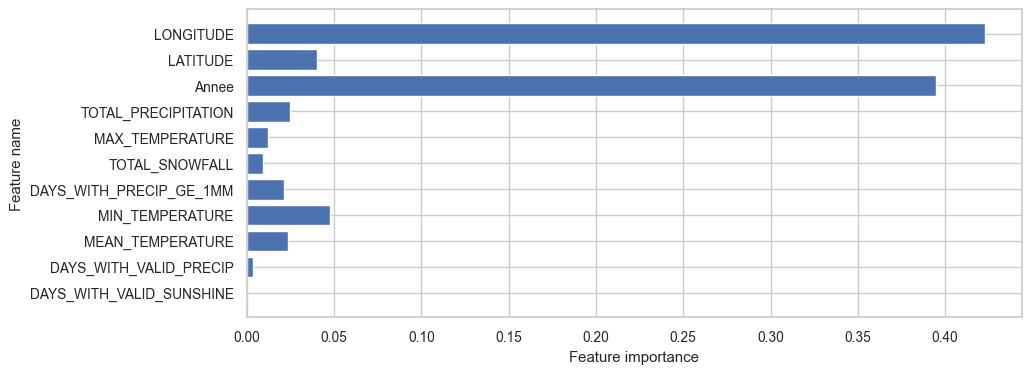

In [35]:
plt.figure(figsize=(10,4))
c_features = len(X_train_scaled.columns)
plt.barh(range(c_features), forest_regressor.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train_scaled.columns)
plt.show()

<span style='font-size:22px'>Nous pouvons voir que l'année et la longitude sont les deux variables qui ont le plus contribué.</span>

### Régression linéaire

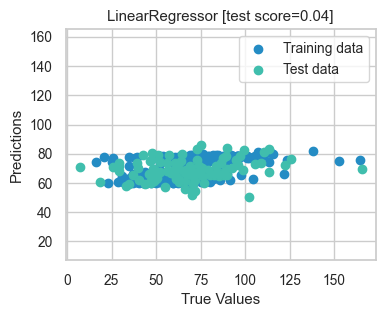

In [36]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)
test_score = linear_regressor.score(X_test_scaled, y_test)
train_score = linear_regressor.score(X_train_scaled, y_train)
y_pred = linear_regressor.predict(X_test_scaled)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', y_train=y_train, y_train_pred=y_train_pred)

In [37]:
print('intercept:', linear_regressor.intercept_)
print('coef:', list(zip(X_train.columns, linear_regressor.coef_) ))

intercept: 68.31915116691103
coef: [('DAYS_WITH_VALID_SUNSHINE', -0.11187799702724881), ('DAYS_WITH_VALID_PRECIP', 0.43000589510847165), ('MEAN_TEMPERATURE', -0.618665402597278), ('MIN_TEMPERATURE', 1.788640559661189), ('DAYS_WITH_PRECIP_GE_1MM', 6.694053794047717), ('TOTAL_SNOWFALL', -0.5728809970735331), ('MAX_TEMPERATURE', -2.206162200980678), ('TOTAL_PRECIPITATION', -6.82208701093058), ('Annee', 4.552550209723729), ('LATITUDE', -2.450783117499322), ('LONGITUDE', -1.8588840167524783)]


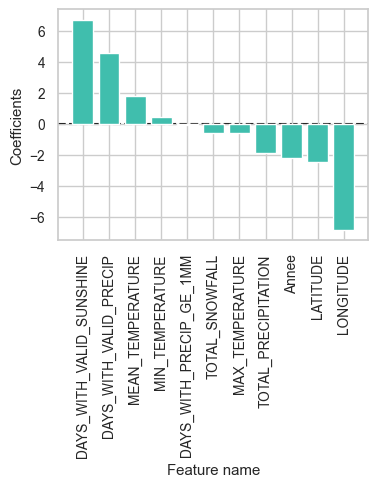

In [38]:
coefficients = pd.DataFrame(list(zip(X_train.columns, linear_regressor.coef_)), 
                            columns=['features', 'coefficients'])
coefficients.sort_values(by='coefficients', ascending=False, inplace=True)
plt.figure(figsize=(4,3))
plt.bar(range(len(coefficients)), coefficients.coefficients, color=colors[0])
plt.ylabel("Coefficients")
plt.xlabel("Feature name")
plt.xticks(np.arange(len(coefficients)), X_train_scaled.columns, rotation=90)
plt.axhline(y=0, color='black', linestyle='--', zorder=-1000)
plt.show()

### À votre tour 

<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Que pouvez-vous conclure jusqu'à présent ? 

Encore une fois les résultats ne sont pas très bons.  Regardons la différence entre la valeur prédite et la vraie valeur

In [39]:
res = pd.DataFrame(list(zip(y_pred, y_test)), columns=['pred', 'test'], index=y_test.index)
res['Annee'] = df.loc[y_test.index, 'Annee'].astype(int)
res['Region'] = df.loc[y_test.index, 'Region']
res['Ensemencee'] = df.loc[y_test.index, 'Ensemencee']
res['Recoltee'] = df.loc[y_test.index, 'Recoltee']
res['Rendement'] = df.loc[y_test.index, 'Rendement']
res['diff'] = res.pred - res.test
res.sort_values('diff', inplace=True)
res.head()

,pred,test,Annee,Region,Ensemencee,Recoltee,Rendement,diff
528,69.522632,165.176206,2013,Durham,896.966663,691.240364,165.176206,-95.653574
505,50.084557,102.000000,2008,Huron,900.000000,800.000000,102.000000,-51.915443
522,72.588353,122.149869,2021,Nipissing,2613.658317,2515.211939,122.149869,-49.561516
524,76.272407,125.695440,2021,Lambton,2954.099423,1537.928764,125.695440,-49.423034
518,67.727179,113.430796,2021,Timiskaming,2533.238061,2437.820802,113.430796,-45.703616


<Axes: >

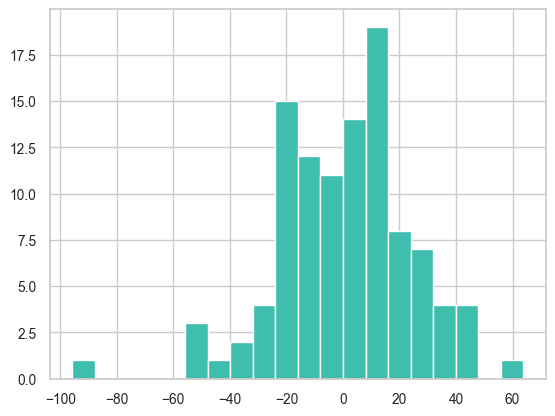

In [40]:
res['diff'].hist(bins=20, color=colors[0])

### Régression linéaire avec la librairie statsmodels

In [41]:
# Autre package pour effectuer des regressions rapidement.  Nous allons l'utiliser pour calculer les p-values
X_sm = X_train_scaled.copy()
X_sm = sm.add_constant(X_sm)
model = sm.OLS(y_train, X_sm).fit()

In [42]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Rendement   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.293
Date:                Mon, 17 Jul 2023   Prob (F-statistic):           7.62e-08
Time:                        23:22:54   Log-Likelihood:                -1810.9
No. Observations:                 423   AIC:                             3646.
Df Residuals:                     411   BIC:                             3694.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Quels sont les autres modèles que nous pourrions essayer ?

Nous nous rendons compte que nous devons bien nous organiser pour tester différents pré-traitements, modèles et hyperparamètres. 
Ceci doit être fait en utilisant une stratégie de validation croisée pour s'assurer que le modèle final puisse généraliser à des données jamais vues.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    
<img src="https://scikit-learn.org/stable/_static/ml_map.png" width='1200px'/>

## Pipelines de Scikit Learn 

Il y a plusieurs combinaisons possibles à tester.  Nous nous retrouvons rapidement avec plusieurs expériences à organiser.  

Aussi, si on obtient un résultat intéressant, on veut savoir exactement les paramètres que nous avons utilisés.  

Les pipelines de scikit-learn nous aide à nous organiser et font sauver du temps et des lignes de code.  Nous pourrions aussi utiliser des logiciels comme kedro ou Knime.   L'application d'algorithme d'apprentissage de façon automatique (auto ML de Google, auto_sklearn) est aussi de plus en plus populaire.

Une pipeline applique séquentiellement différentes opérations.

Dans les pipelines de `scikit-learn`, nous retrouvons 2 concepts importants:

* les transformateurs (transformer) qui offrent les fonctions `fit` et `transform`
* les estimateurs (estimators) qui offrent les fonctions`fit` et `predict`

La fonction `make_pipeline` gère l'enchainement des différentes étapes de pré-traitement et d'entrainement.

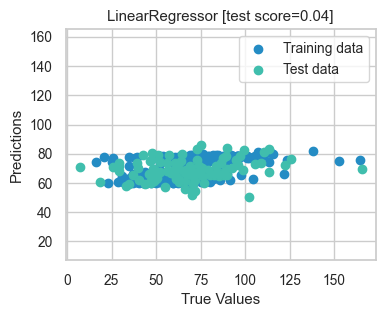

In [43]:
pipeline = make_pipeline(SimpleImputer(), StandardScaler(), LinearRegression(fit_intercept=True))
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
test_score = pipeline.score(X_test, y_test)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', y_train=y_train, y_train_pred=y_train_pred)

La classe `Pipeline` gère aussi l'enchainement séquentiel des différentes étapes.  Ici, nous avons besoin de nommer les étapes.  Avec `make_pipeline`, les noms sont créés automatiquement.

Nous pouvons passer l'objet `pipeline` à la méthode `cross_val_score` pour effectuer la validation croisée. 

In [44]:
results = []
estimator_names = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR']
for estimator in estimator_names:
    pipeline = Pipeline([ ('imputer', IterativeImputer(max_iter=10, random_state=0)),
                          ('scaler', StandardScaler()),
                          ('estimator', eval(estimator)()) 
                            ])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
    results.append([estimator, np.mean(scores), np.std(scores), 'Rendement'])
    
results = pd.DataFrame(results, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results

,Model,Mean Score,Std Score,Dataset
0,LinearRegression,-0.024819,0.254371,Rendement
1,RandomForestRegressor,0.094762,0.264164,Rendement
2,DecisionTreeRegressor,-0.596025,0.393163,Rendement
3,KNeighborsRegressor,0.072881,0.189950,Rendement
4,GradientBoostingRegressor,-0.018857,0.305787,Rendement
5,SVR,0.028450,0.127442,Rendement


Un coefficient de détermination négatif indique que quelque chose ne fonctionne pas.  Cela indique que le modèle de régression n'est pas capable de capturer la variation des données et qu'il effectue des prédictions moins précices qu'en utilisant simplement la moyenne.  

Quoi faire ?

* S'assurer que le code est correct 
* Vérifier les données tant les variables prédictives que la variable à prédire
* Retourner aux données pour comprendre le problème

Comme nous n'obtenons pas de très bons résultats, nous pouvons tester notre code avec des données sythétiques en utilisant la fonction `make_regression`.

In [45]:
X_tmp, y_tmp = make_regression(n_samples=X.shape[0], n_features=X.shape[1])

results_tmp = []
for estimator in estimator_names:
    pipeline = make_pipeline(IterativeImputer(), StandardScaler(), eval(estimator)())
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_tmp, y_tmp, cv=cv, n_jobs=-1)
    results_tmp.append([estimator, np.mean(scores), np.std(scores), 'scikit-learn'])

results_tmp = pd.DataFrame(results_tmp, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results_tmp

,Model,Mean Score,Std Score,Dataset
0,LinearRegression,1.000000,0.000000,scikit-learn
1,RandomForestRegressor,0.743951,0.042821,scikit-learn
2,DecisionTreeRegressor,0.322283,0.090875,scikit-learn
3,KNeighborsRegressor,0.738876,0.028382,scikit-learn
4,GradientBoostingRegressor,0.875042,0.019904,scikit-learn
5,SVR,0.070436,0.017864,scikit-learn


### À votre tour 

<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Que concluez-vous de ces résultats ?

## Trouver les bons paramètres et le bon modèle

Chaque algorithme d'apprentissage a ses particularités et certains modèles sont plus appropriés pour certains types de données et problèmes.  

En tenant compte de nos contraintes pratiques, nous voulons tester différents algorithmes sur les données traitées de différentes façons.  Nous voulons aussi optimiser les hyperparamètres des algorithmes testés.  

Cela fait beaucoup de combinaisons possibles.  Les `pipeline`de `scikit-learn` favorisent la traçabilité, la reproductibilité et l'automatisation.


In [46]:
estimator_names = ['LinearRegression', 'RandomForestRegressor',  'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR', 'DummyRegressor']

estimator_params = {'RandomForestRegressor': {'estimator__max_depth': [4, 6, 8, 10, 12]}}

res = []
for estimator in estimator_names:  
    pipeline = Pipeline([('imputer', None),('scaler', None), ('estimator', eval(estimator)())])
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()]}
   
    parameters.update(estimator_params.get(estimator, {}))
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring="r2")  
    grid_search.fit(X_train, y_train) 
    cv_results = grid_search.cv_results_
    best_estimator = grid_search.best_estimator_     
    res.append([estimator, grid_search.best_score_, grid_search.best_params_, cv_results, best_estimator]) 

In [47]:
res = pd.DataFrame(res, columns=['Model', 'Best_Score', 'Best_parameters', 'CV_Results', 'Best_estimator'])
#res.to_csv('prediction_rendement_20230707.csv')

Regardons les résultats obtenus

In [48]:
res

,Model,Best_Score,Best_parameters,CV_Results,Best_estimator
0,LinearRegression,0.044025,"{'imputer': SimpleImputer(), 'scaler': MinMaxS...","{'mean_fit_time': [0.0062653541564941405, 0.00...","(SimpleImputer(), MinMaxScaler(), LinearRegres..."
1,RandomForestRegressor,0.182574,"{'estimator__max_depth': 12, 'imputer': Iterat...","{'mean_fit_time': [0.17006912231445312, 0.2133...","(IterativeImputer(), RobustScaler(), (Decision..."
2,KNeighborsRegressor,0.158199,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.009082841873168945, 0.004...","(SimpleImputer(), StandardScaler(), KNeighbors..."
3,GradientBoostingRegressor,0.064767,"{'imputer': SimpleImputer(), 'scaler': MinMaxS...","{'mean_fit_time': [0.15132479667663573, 0.1422...","(SimpleImputer(), MinMaxScaler(), ([DecisionTr..."
4,SVR,0.073875,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.009676361083984375, 0.008...","(SimpleImputer(), StandardScaler(), SVR())"
5,DummyRegressor,-0.005849,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.003454113006591797, 0.003...","(SimpleImputer(), StandardScaler(), DummyRegre..."


À quoi ressemblent les résultats de validation croisée ? 

In [49]:
res['CV_Results'][0]

{'mean_fit_time': array([0.00626535, 0.00433159, 0.006253  , 0.02241335, 0.02195802,
        0.02342219]),
 'std_fit_time': array([0.0026069 , 0.00033597, 0.00023725, 0.00133013, 0.00092011,
        0.00136583]),
 'mean_score_time': array([0.00197477, 0.00167246, 0.00184927, 0.00213842, 0.00222435,
        0.00183702]),
 'std_score_time': array([4.03477936e-04, 2.85353292e-04, 3.12648514e-04, 4.59911068e-04,
        3.80187520e-04, 7.88098014e-05]),
 'param_imputer': masked_array(data=[SimpleImputer(), SimpleImputer(), SimpleImputer(),
                    IterativeImputer(), IterativeImputer(),
                    IterativeImputer()],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_scaler': masked_array(data=[StandardScaler(), MinMaxScaler(), RobustScaler(),
                    StandardScaler(), MinMaxScaler(), RobustScaler()],
              mask=[False, False, False, False, False, False],
        fill_value='?'

### Calcul de différentes métriques pour les meilleurs modèles choisis.

In [50]:
metric_names = [ "mean_absolute_error", 'mean_squared_error', "r2_score"] # même nom que dans la librairie

mymetrics = []
for row in res.to_dict('records'):
    model = row['Model']
    estimator = row['Best_estimator']
    pred_test = estimator.fit(X_train, y_train).predict(X_test)
    m = []
    for metric_name in metric_names:
        m.append(eval(f'{metric_name}(y_test, pred_test)'))
    mymetrics.append([model] + m)
mymetrics =  pd.DataFrame(mymetrics, columns=['Model'] + metric_names)

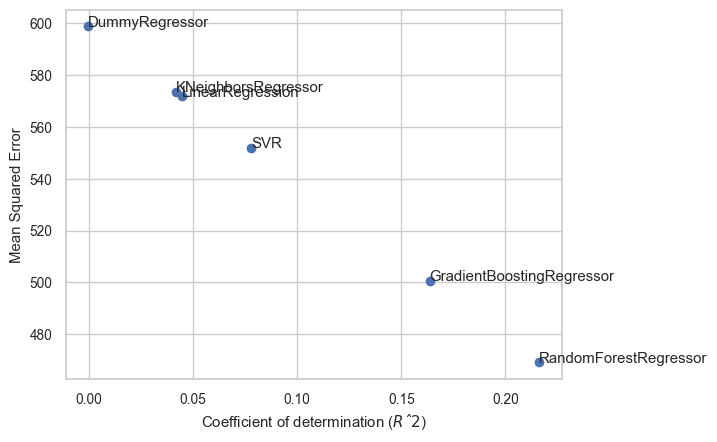

In [52]:
plt.scatter(mymetrics.r2_score, mymetrics.mean_squared_error)
for i in range(mymetrics.shape[0]):
    plt.text(mymetrics.r2_score[i], mymetrics.mean_squared_error[i], s=mymetrics.Model[i])
plt.ylabel('Mean Squared Error')
plt.xlabel('Coefficient of determination ($Rˆ2$)')
plt.show()

Voici un article s'intéressant à la prédiction du rendement: <br>
    https://www.frontiersin.org/articles/10.3389/fpls.2019.00621/full

Et un rapport produit dans le cadre d'une compétition:<br>
https://github.com/WizzX7/Morgan-Stanley-Quant-Challange/blob/main/quant_documentation.pdf
